# Multiple Linear Regression using `keras`

As the [Keras Documentation](http://keras.io/) states, "Keras is a minimalist, highly modular neural networks library, written in Python and capable of running on top of either TensorFlow or Theano". While it's not really meant to be used to perform multiple linear regression, we'll walk through it using `keras` to continue with the theme of building up from linear regression to neural networks. 

## Computational Graphs for Multiple Linear Regression 

As a reference, the computational graphs that we used to visualize the forward and backward propagation steps in solving our multiple linear regression problem with gradient descent are as follows: 
### Forward Propagation

<img src="../imgs/custom/mult_linear_comp_graph_condensed_forprop.png" width=300\>

### Backward Propagation

<img src="../imgs/custom/mult_linear_comp_graph_condensed_backprop.png" width=400\>

### Performing Multiple Linear Regression with Keras

Since `keras` can be run on top of either `tensorflow` or `theano`, this means that under the hood of our multiple linear regression using `keras`, a similar version of the code that we wrote in our `theano` or `tensorflow` implementation is being run. By default, `keras` runs on `theano`, but by [adjusting our keras configuration file](http://keras.io/backend/#switching-from-one-backend-to-another), we can easily change that. For now, though, we'll just run it on `theano`. 

In [1]:
import numpy as np
from keras.layers import Input
from keras.layers.core import Dense
from keras.models import Model
from keras.optimizers import SGD
from datasets.general import gen_multiple_linear
from utils.plotting import plot_errors
%matplotlib inline

Using Theano backend.


In [2]:
def get_keras_model(): 
    learning_rate = 0.1
    # 1. Specify a placeholder for the inputs. 
    xs = Input(shape=(4,))
    # 2. Define the equation that generates predictions. 
    ys = Dense(1, activation='linear', bias=False)(xs)

    # 3. Define a `Model` object that will be used to train/learn the coefficients. 
    linear_model = Model(input=xs, output=ys)
    
    # 4. Define the optimizer and loss function used to train/learn the coefficients. 
    sgd = SGD(learning_rate)
    
    # 5. Compile the model (basically, build up the backpropagation steps)
    linear_model.compile(loss='mean_squared_error', optimizer=sgd)
    
    return linear_model

Our `get_keras_model` function returns back what our `get_theano_graph` ([notebook 2c](https://github.com/sallamander/neural-networks-intro/blob/master/mini-books/shallow-neural-networks/02-multiple-linear/2c_nn_th.ipynb)) and `get_tensorflow_graph` ([notebook 2d](https://github.com/sallamander/neural-networks-intro/blob/master/mini-books/shallow-neural-networks/02-multiple-linear/2d_nn_tf.ipynb)) functions returned - a set of computations that perform forward and backward propagation in order to solve a multiple linear regression problem using gradient descent. 

Compared to prior implementations, our `get_keras_model` has a smaller code base, which makes sense given it's goal to be a "minimalist, highly modular neural networks library". We see that our forward propagation is defined in 2 steps, compared to the 5 steps it took with `theano` or `tensorflow`: 

* Step `1` is simply the `keras` way of generating a placeholder variable that will later be replaced with real data. The one piece of information we have to provide is the dimensionality of one of our input observations (e.g. how many features it has). Since we specified that we would have three features and added a column of ones into our `xs` to account for the intercept (
<img src="../imgs/variables/beta0.png" style="vertical-align: text-middle; display: inline-block; padding-top:0; margin-top:0;" width=20 \>
), our `shape` needs to have 4 dimensions.  
* Step `2` defines our multiple linear regression equation, <img src="../imgs/equations/mult_linear_3_feats.png" width=125 style="vertical-align: text-middle; display: inline-block; padding-top:0; margin-top:0;" \>. We'll detail the `Dense` class at a later point when we cover some of the terminology of neural networks. For now, just trust that it defines our multiple linear regression equation. 

Backward propagation is defined in steps `4-5`: 

* Step `4` specifies exactly how to perform our gradient descent updates. Here, we'll use what we've used in all of our prior implementations - gradient descent with a learning rate of 0.1. As we'll see in later notebooks, there are a number of more complicated flavors of gradient descent that we also have the option to use.
* Step `5` tells `keras` to calculate the update rules for our coefficients, defining each of the steps necessary for doing so. Here, we have to specify a `loss` as well as an `optimizer`. As discussed above, the `optimizer` specifies how to perform our gradient descent updates. The `loss` function specifies how we calculate the error, which up to this point has been using squared error. After defining both a `loss` and `optimizer`, `keras` has all of the pieces it needs to calculate the update rules for our coefficients, and to add those update steps into the graph that it will later run through. 

Step `3` builds a model object that we can later use to learn our coefficients. To instantiate it, we have to specify `input` as well as `output`. In order to finish building it for later use, we have to run `compile` on it like we did in step `5`. 

Let's now use our `keras` model to actually solve a multiple linear regression problem...

Final Error: 1.278908923207922e-10


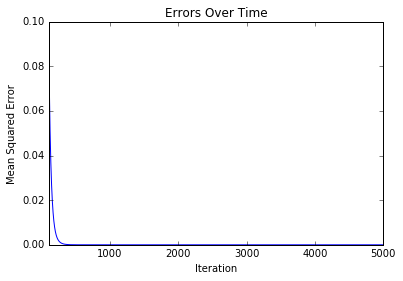

In [3]:
# Randomly generate our betas and number of observations, used to generate 
# fake data to fit. We should have a minimum of 4 obs, since we have 
# four coefficients. 
true_betas_array = np.random.randint(2, 10, size=4)
n_obs = np.random.randint(9500, 10500) 

# Generate the data that follows a linear relationship specified 
# by `true_betas_array`. 
xs, ys = gen_multiple_linear(true_betas_array, n_obs)

# Generate the keras model.
linear_model = get_keras_model()

# Learn the coefficients (perform iterations of forward and backward propagation)
linear_model.fit(xs, ys, nb_epoch=5000, verbose=0, batch_size=n_obs)
# The history attribute holds a history dictionary that we can use to access the
# loss (mean squared error) after each iteration. 
mean_squared_errors = linear_model.history.history['loss']
# Skip the first 100 values because it pulls the y-axis up quite a bit. 
plot_errors(mean_squared_errors, iterations=(100, 5000))
print("Final Error: {}".format(mean_squared_errors[-1]))

Just as with simple linear regression, running our `keras` model is fairly straightforward. We simply call `fit` on it, making sure to pass in our inputs and outputs (`xs` and `ys`) and specify how many iterations of forward and backward propagation to perform over our dataset (this is the `nb_epoch` argument). We also specify the `batch_size` to control how many observations the model looks at in each individual foward/backward propagation step (right now we want it to just look at all of them). We'll detail these parameters more later as we dive into neural networks.

Upon running it, we can see that we are also able to solve our multiple linear regression problem using `keras`, and that we obtain the expected coefficients. Next, we'll prove to ourselves that we can also solve multiple logistic regression using this same gradient descent procedure. 